In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import RecursiveFeatureElimination
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve, roc_curve 
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
from time import perf_counter

In [2]:
df=pd.read_csv('uci-secom.csv', sep=',')    

In [3]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1] 

y = y.replace({-1: 0})

seed = 101 

kf = StratifiedKFold(4, shuffle = True, random_state = seed)

In [4]:
X = X.sample(frac=1, random_state = seed)
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

X_copy = X_train.copy()
n = len(X_copy)
n_sqrt = int(n ** 0.5)

In [5]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = n_sqrt)),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = 1e3,
                                     class_weight = 'balanced'))
])

records = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}

In [6]:
def info_resume(X, procedure = 'Nothing', record = None):
    
    if record is None:
        record = {'cv_ap_score': [],
           'training_time': [],
           'procedure': []}
        
    
    num_feats = len(X_copy.columns)
    
    rec = dict()
    record_copy = record.copy()
    
    times = []
    
    for i in range(10):
        start = perf_counter()
        pipe_lr.fit(X, y_train)
        end = perf_counter()
        times.append(end-start)
        
    
    cv_mean = cross_val_score(pipe_lr, X, y_train, cv = kf, scoring = 'average_precision').mean()
    
    rec['cv_ap_score'] = cv_mean
    rec['training_time'] = (np.mean(times))
    rec['procedure'] = f'{procedure} ({num_feats})'
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    
    fig.suptitle(f'CV AP Score: {cv_mean:.3f}, Training Time: {(end-start):.3f} seconds, Procedure: {procedure}')
    ax[0].set_title(f'Missing Values:   {X_copy.isnull().sum().sum() / (n * len(X_copy.columns)) * 100:.2f} %')
    sns.heatmap(X.isnull(), ax = ax[0]);
    ax[1].set_title(f'Number of Columns: {num_feats:3d}')
    sns.heatmap(X.corr(), ax = ax[1]);
    fig.tight_layout()

    for k, v in rec.items():
        record_copy[k].append(v)
    
    return record_copy

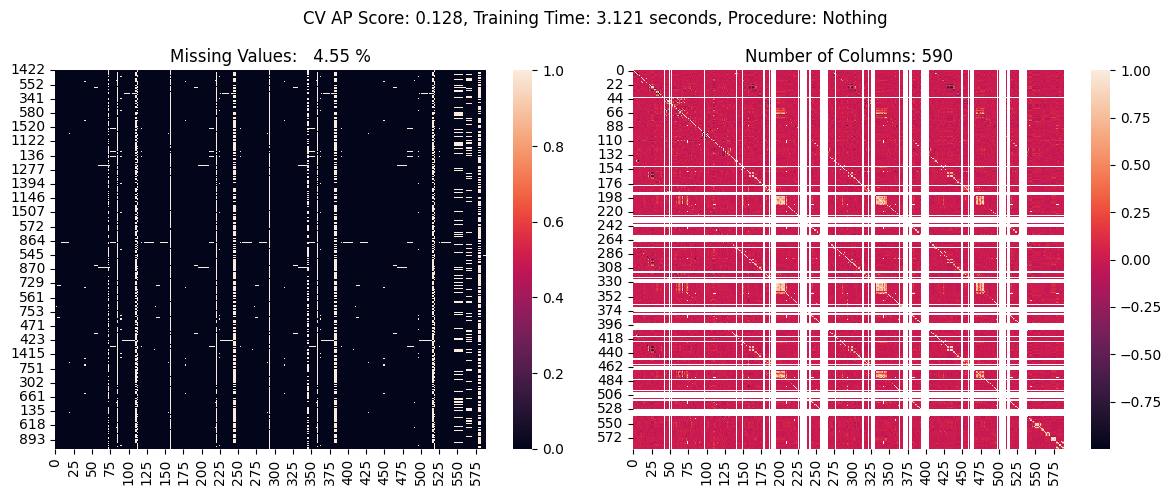

In [7]:
records = info_resume(X_copy, 'Nothing', records)

unspervised feature selection

drop constant features

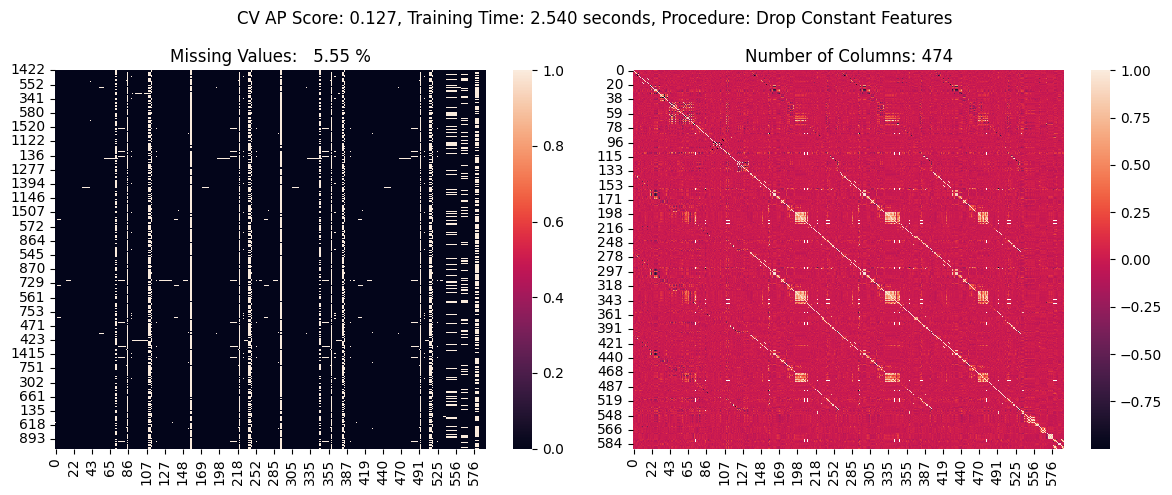

In [8]:
X_copy = DropConstantFeatures(missing_values='ignore').fit_transform(X_copy)

records = info_resume(X_copy, 'Drop Constant Features', records)

drop correlated features

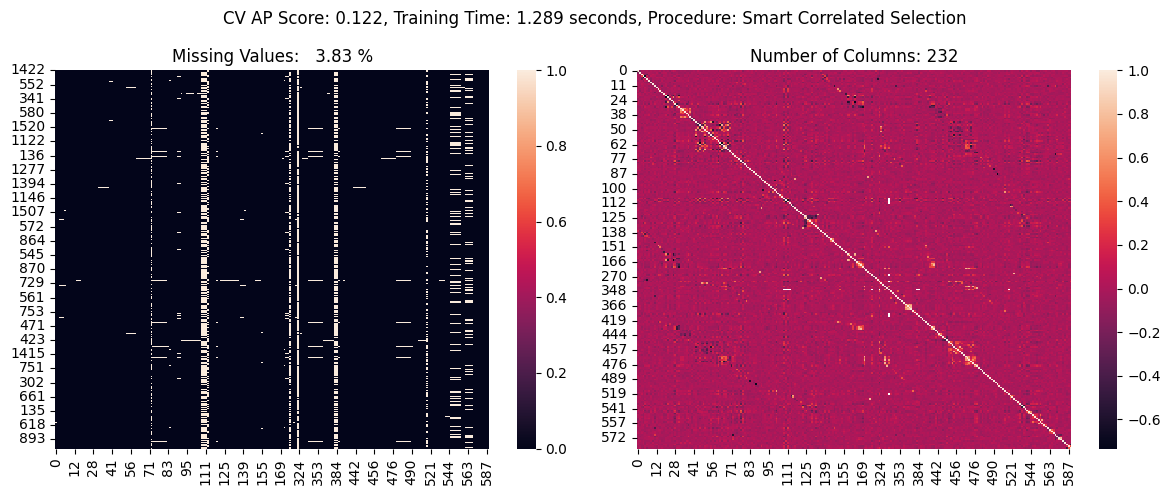

In [9]:
X_copy = SmartCorrelatedSelection(threshold=0.8, selection_method='missing_values').fit_transform(X_copy)

records = info_resume(X_copy, 'Smart Correlated Selection', records)

drop most missing features

In [10]:
miss_series = X_copy.isnull().sum() / len(X_copy)

miss_series.sort_values(ascending = False).head(22) 

292    0.910615
111    0.646449
110    0.646449
109    0.646449
382    0.646449
384    0.646449
245    0.646449
73     0.512370
112    0.458899
519    0.458899
563    0.173184
568    0.173184
567    0.173184
562    0.173184
547    0.168396
553    0.168396
548    0.168396
555    0.168396
557    0.168396
546    0.168396
224    0.032721
90     0.032721
dtype: float64

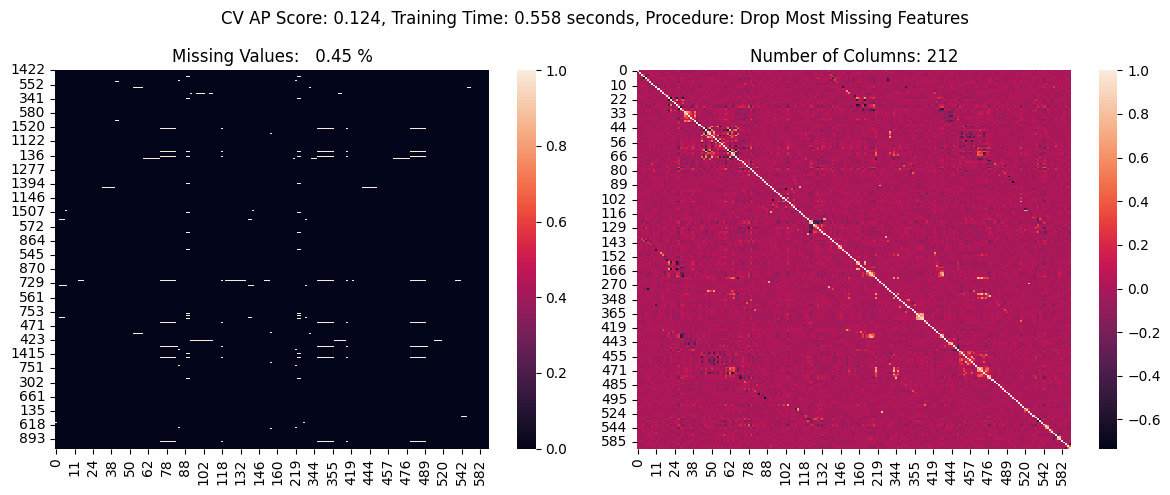

In [11]:
drop_miss = miss_series.loc[miss_series > 0.10]

X_copy = X_copy.drop(drop_miss.index, axis = 1)

records = info_resume(X_copy, 'Drop Most Missing Features', records)

supervised feature selection

drop least target correlated

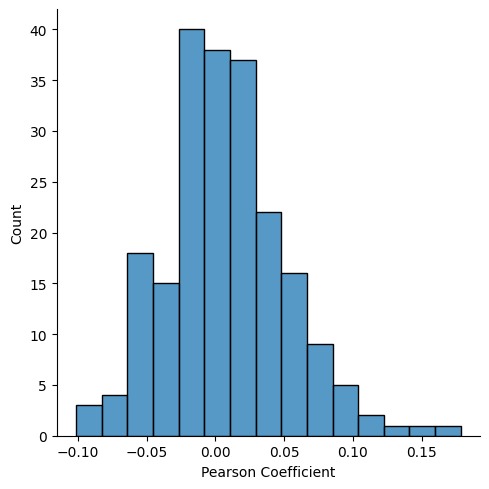

In [12]:
df = pd.concat([X_copy, y], axis = 1)
series = df.corr().iloc[:-1, -1]
series.name = 'Pearson Coefficient'

sns.displot(series, bins = 15);

In [13]:
def pearson_drop(X, y, threshold):
    df = pd.concat([X, y], axis = 1)
    series = df.corr().iloc[:-1, -1]
    series = series.loc[np.abs(series) > threshold] 
    return X.loc[:, series.index]

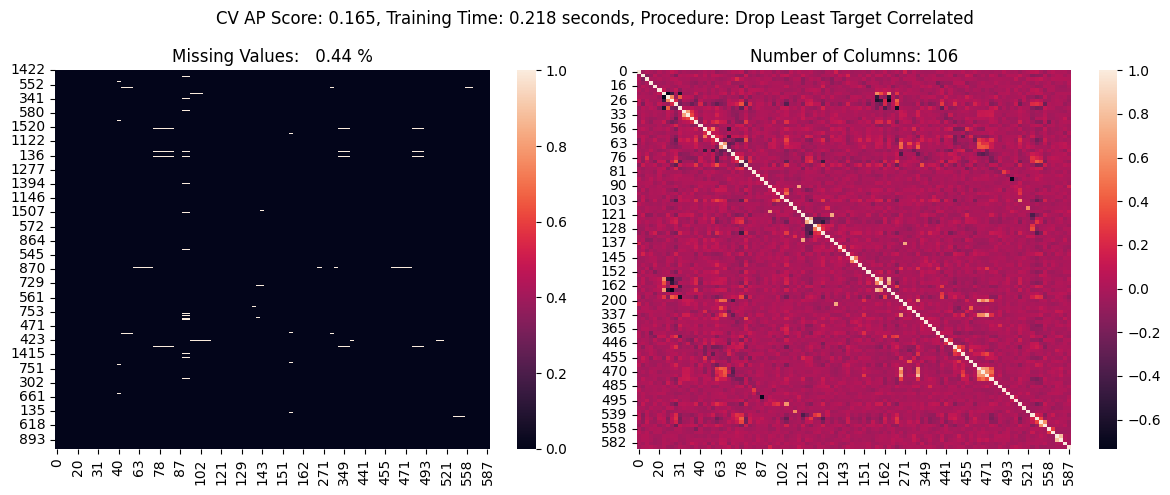

In [14]:
X_copy = pearson_drop(X_copy, y_train, 0.025)

records = info_resume(X_copy, 'Drop Least Target Correlated', records)

recursive feature elimination

In [15]:
def recursive_feature_elimination(X, y, kf, verbose = False):
    
    model = pipe_lr.fit(X, y)
    coefs = model.named_steps['estimator'].coef_
    args = np.argsort(np.abs(coefs))
    ord_feats = np.array(X.columns)[args][0]
    X = X.loc[:, ord_feats]
    
    cv_mean = []
    cv_std = []
    
    for i in range(len(X.columns) - 1):
        
        cv_score = cross_val_score(pipe_lr, X, y, cv = kf, scoring = 'average_precision')
        cv_mean.append(cv_score.mean())
        cv_std.append(cv_score.std())
        
        X = X.iloc[:, 1:]
        
        if verbose:
            print(f'Features Evaluated: {i:2d}, score: {cv_score.mean():.3f}')
    
    return np.array(cv_mean[::-1]), np.array(cv_std[::-1]), ord_feats[::-1]

cv_mean, cv_std, ord_feats = recursive_feature_elimination(X_copy, y_train, kf, True)

Features Evaluated:  0, score: 0.165
Features Evaluated:  1, score: 0.165
Features Evaluated:  2, score: 0.167
Features Evaluated:  3, score: 0.171
Features Evaluated:  4, score: 0.175
Features Evaluated:  5, score: 0.176
Features Evaluated:  6, score: 0.181
Features Evaluated:  7, score: 0.182
Features Evaluated:  8, score: 0.184
Features Evaluated:  9, score: 0.180
Features Evaluated: 10, score: 0.184
Features Evaluated: 11, score: 0.185
Features Evaluated: 12, score: 0.185
Features Evaluated: 13, score: 0.190
Features Evaluated: 14, score: 0.195
Features Evaluated: 15, score: 0.199
Features Evaluated: 16, score: 0.193
Features Evaluated: 17, score: 0.200
Features Evaluated: 18, score: 0.194
Features Evaluated: 19, score: 0.192
Features Evaluated: 20, score: 0.195
Features Evaluated: 21, score: 0.192
Features Evaluated: 22, score: 0.196
Features Evaluated: 23, score: 0.192
Features Evaluated: 24, score: 0.193
Features Evaluated: 25, score: 0.193
Features Evaluated: 26, score: 0.193
F

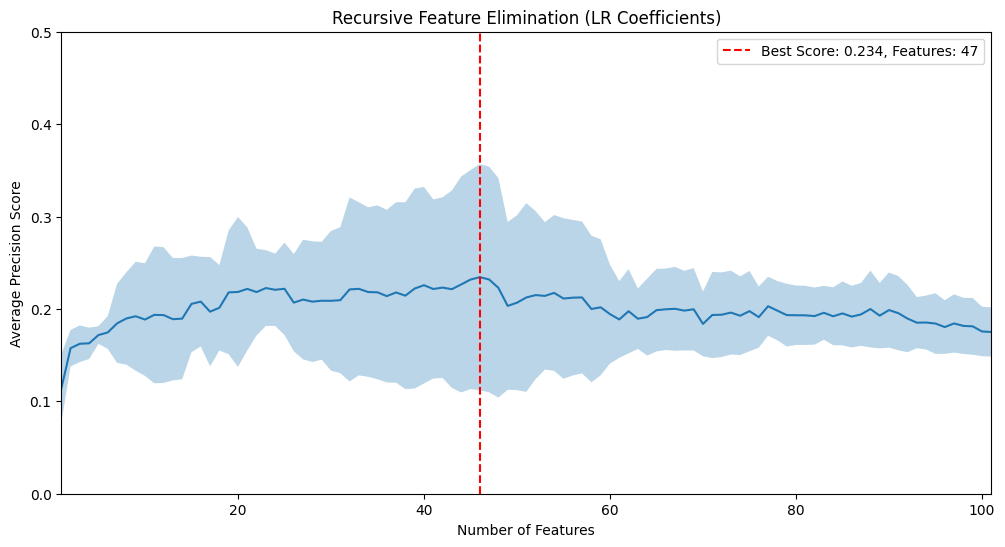

In [16]:
arg = np.argmax(cv_mean)
max_ap = np.max(cv_mean)

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(range(1, len(ord_feats)), cv_mean)
ax.fill_between(range(1, len(ord_feats)), cv_mean - cv_std, cv_mean + cv_std, alpha = 0.3)
ax.set_xlim(1, 101)
ax.set_ylim(0, 0.5)
ax.axvline(arg+1, ls = '--', color = 'r', label = f'Best Score: {max_ap:.3f}, Features: {arg+2}')
ax.set_ylabel('Average Precision Score')
ax.set_xlabel('Number of Features')
ax.grid(False)
ax.set_title('Recursive Feature Elimination (LR Coefficients)')
ax.legend();

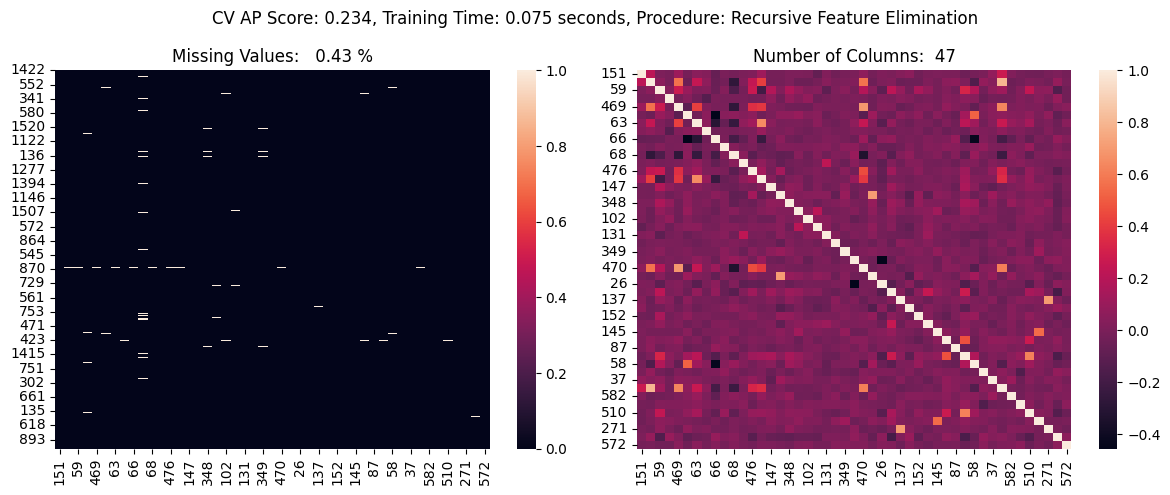

In [17]:
X_copy = X_train.loc[:, ord_feats[:arg+2]]

records = info_resume(X_copy, 'Recursive Feature Elimination', records);

hyperparameter optimization

In [18]:
selected_feats = X_copy.columns

X_train = X_train.loc[:, selected_feats]
X_test = X_test.loc[:, selected_feats]


p_dist1 = {'estimator__C': np.logspace(-1, 2, 100),
          'imputer__n_neighbors': np.linspace(15, 50, 20, dtype = int),
          'estimator__class_weight': [{0: 1, 1: w} for w in np.linspace(10, 60, 100)]
         }

search1 = RandomizedSearchCV(pipe_lr, p_dist1, n_iter = 400, cv = kf, verbose=False, scoring = 'average_precision')

In [19]:
search1.fit(X_train, y_train);

In [20]:
df_cv_results1 = pd.DataFrame(search1.cv_results_)

df_cv_results1['class_weight'] = df_cv_results1['param_estimator__class_weight'].apply(lambda x: x[1])

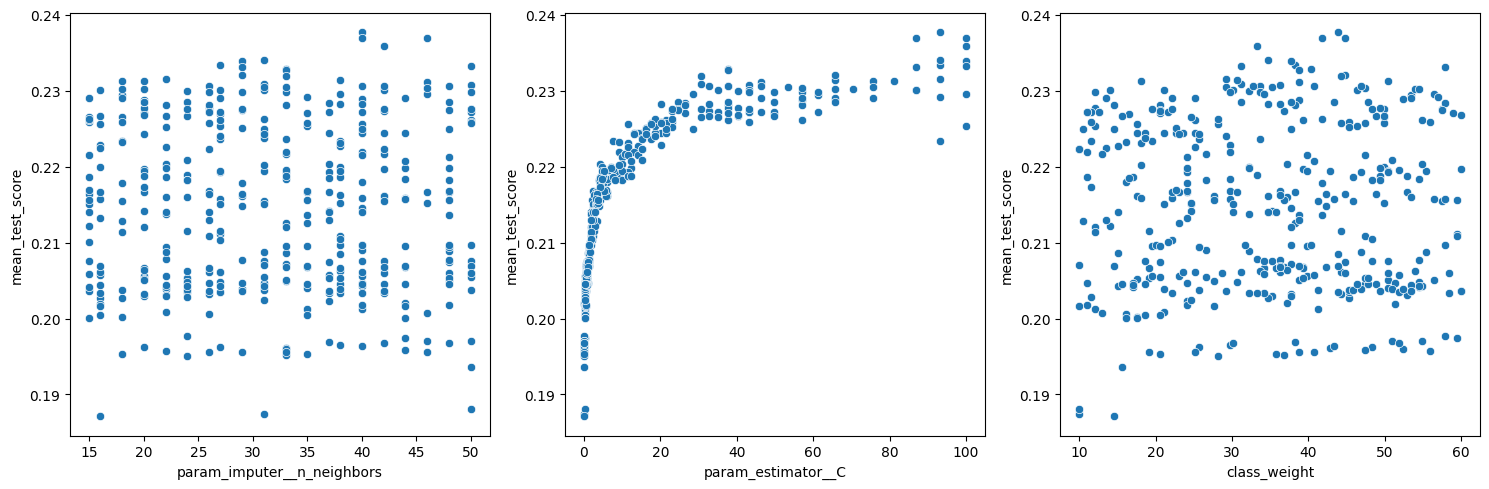

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(data = df_cv_results1, 
                x = 'param_imputer__n_neighbors', 
                y = 'mean_test_score', ax = ax[0])
sns.scatterplot(data = df_cv_results1,
                x = 'param_estimator__C',
                y = 'mean_test_score', ax = ax[1])
sns.scatterplot(data = df_cv_results1,
                x = 'class_weight',
                y = 'mean_test_score', ax = ax[2])

fig.tight_layout()

In [22]:
best = search1.best_params_

best

{'imputer__n_neighbors': np.int64(40),
 'estimator__class_weight': {0: 1, 1: np.float64(43.83838383838384)},
 'estimator__C': np.float64(93.26033468832199)}

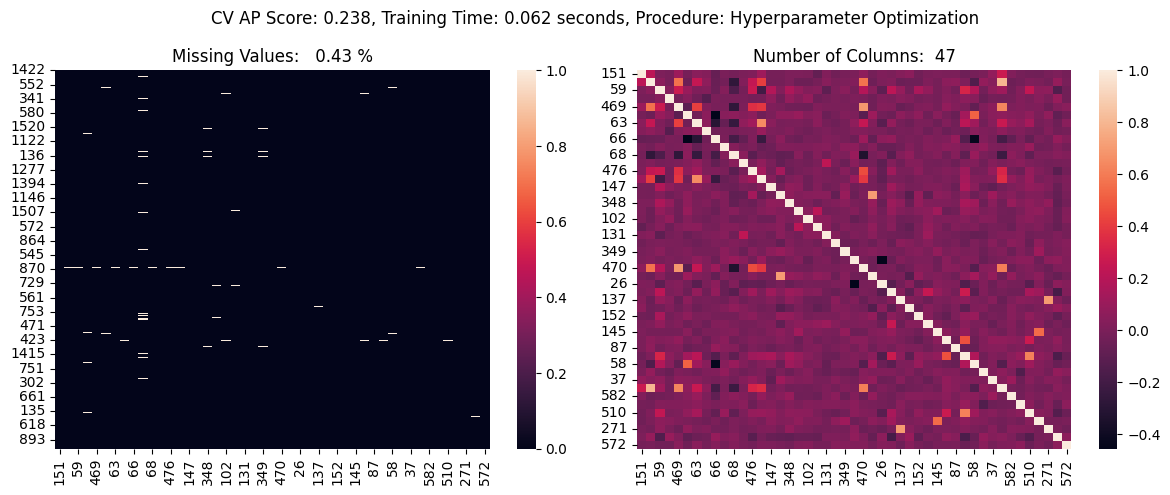

In [23]:
pipe_lr = Pipeline(steps = [
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer(n_neighbors = best['imputer__n_neighbors'])),
    ('estimator', LogisticRegression(penalty = 'l2', 
                                     solver = 'liblinear', 
                                     max_iter = int(1e5),
                                     C = best['estimator__C'],
                                     class_weight = best['estimator__class_weight']))
])

records = info_resume(X_train, 'Hyperparameter Optimization', records)

model evaluation

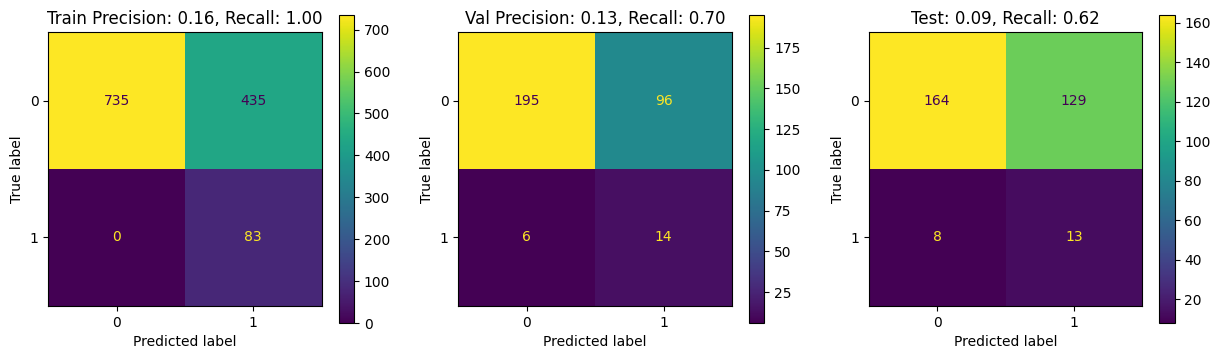

In [24]:
cm_val = 0

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index] 
    
    pipe_lr.fit(X_par_train, y_par_train)
    y_pred_val = pipe_lr.predict(X_val)

    cm_val += cm(y_val, y_pred_val)
    
pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
y_pred_train = pipe_lr.predict(X_train)

cm_test = cm(y_test, y_pred)
cm_train = cm(y_train, y_pred_train)
    
cm_val //= 4

val_precision = cm_val[1, 1] / (cm_val[1, 1] + cm_val[0, 1]) 
train_precision = cm_train[1, 1] / (cm_train[1, 1] + cm_train[0, 1])
test_precision = cm_test[1, 1] / (cm_test[1, 1] + cm_test[0, 1])

val_recall = cm_val[1, 1] / (cm_val[1, 1] + cm_val[1, 0]) 
train_recall = cm_train[1, 1] / (cm_train[1, 1] + cm_train[1, 0])
test_recall = cm_test[1, 1] / (cm_test[1, 1] + cm_test[1, 0])

fig, ax = plt.subplots(1, 3, figsize = (15, 4))

plot1 = ConfusionMatrixDisplay(cm_train)
plot2 = ConfusionMatrixDisplay(cm_val)
plot3 = ConfusionMatrixDisplay(cm_test)

plot1.plot(ax = ax[0]) 
plot2.plot(ax = ax[1])
plot3.plot(ax = ax[2]);

ax[0].set_title(f'Train Precision: {train_precision:.2f}, Recall: {train_recall:.2f}')
ax[1].set_title(f'Val Precision: {val_precision:.2f}, Recall: {val_recall:.2f}')
ax[2].set_title(f'Test: {test_precision:.2f}, Recall: {test_recall:.2f}');

In [25]:
val_scores = []
val_labels = []

for train_index, val_index in kf.split(X_train, y_train):
    
    X_par_train, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_par_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    pipe_lr.fit(X_par_train, y_par_train)
    val_score = pipe_lr.predict_proba(X_val)[:, 1]
    
    val_scores.append(val_score)
    val_labels.append(y_val)
    
pipe_lr.fit(X_train, y_train)

test_scores = pipe_lr.predict_proba(X_test)[:, 1]
train_scores = pipe_lr.predict_proba(X_train)[:, 1]
    
val_scores = np.concatenate(val_scores)
val_labels = np.concatenate(val_labels)

fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)

pre_train, rec_train, _ = precision_recall_curve(y_train, train_scores)
pre_val, rec_val, _ = precision_recall_curve(val_labels, val_scores)
pre_test, rec_test, _ = precision_recall_curve(y_test, test_scores)

auc_train = roc_auc_score(y_train, train_scores)
ap_train = average_precision_score(y_train, train_scores)

auc_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'roc_auc').mean()
ap_val = cross_val_score(pipe_lr, X_train, y_train, cv = kf, scoring = 'average_precision').mean()

auc_test = roc_auc_score(y_test, test_scores)
ap_test = average_precision_score(y_test, test_scores)

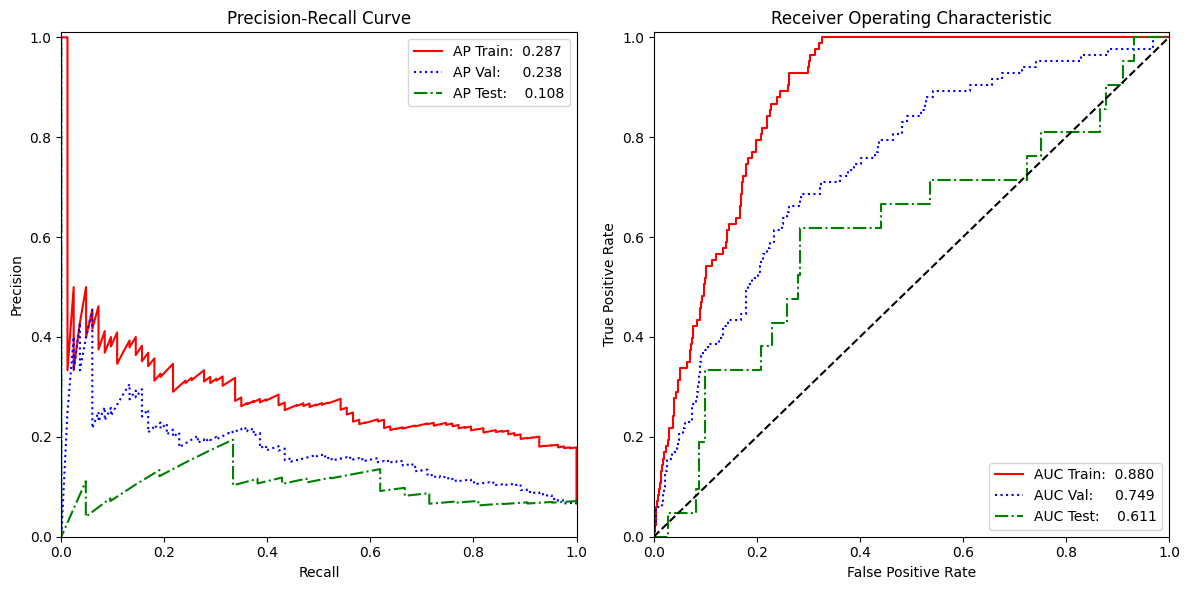

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))


ax[0].plot(rec_train, pre_train, label = f'AP Train:{ap_train:7.3f}', ls = '-', color = 'r')
ax[0].plot(rec_val, pre_val, label = f'AP Val:   {ap_val:7.3f}', ls = ':', color = 'b')
ax[0].plot(rec_test, pre_test, label = f'AP Test:  {ap_test:7.3f}', ls = '-.', color = 'g')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1.01)
ax[0].legend()
ax[0].set_title('Precision-Recall Curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')

ax[1].plot(fpr_train, tpr_train, label = f'AUC Train:{auc_train:7.3f}', ls = '-', color = 'r')
ax[1].plot(fpr_val, tpr_val, label = f'AUC Val:   {auc_val:7.3f}', ls = ':', color = 'b')
ax[1].plot(fpr_test, tpr_test, label = f'AUC Test:  {auc_test:7.3f}', ls = '-.', color = 'g')
ax[1].plot([0, 1], [0, 1], ls = '--', color = 'k')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1.01)
ax[1].legend()
ax[1].set_title('Receiver Operating Characteristic')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate');

fig.tight_layout()

conclusion

Text(0, 0.5, 'Training Time [seconds]')

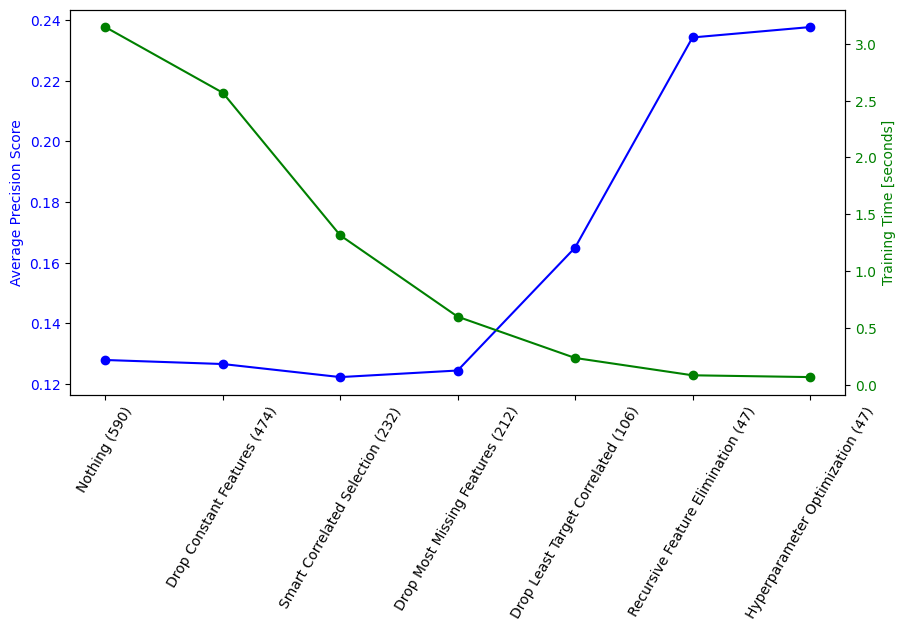

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(records['procedure'], records['cv_ap_score'], marker = 'o', color = 'b')
ax.tick_params(axis='x', labelrotation=60)
ax.tick_params(axis='y', labelcolor='b')
ax.set_ylabel('Average Precision Score', color='b')

ax2 = ax.twinx()

ax2.plot(records['procedure'], records['training_time'], marker = 'o', color = 'g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('Training Time [seconds]', color='g') 

In [28]:
with open('features_selected.txt', 'w') as f:
    for c in X_train.columns:
        f.write(str(c))
        f.write('\n')